* [github](https://github.com/troywu666/Airbnb_data_analyse)
* [blog](https://blog.csdn.net/datawhale/article/details/80847662)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
%matplotlib inline
import datetime
import os
import seaborn as sns#数据可视化
from datetime import date
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
import pickle #用于存储模型
import seaborn as sns
from sklearn.metrics import *
from sklearn.model_selection import *

导入数据

In [2]:
train=pd.read_csv("./input/train_users_2.csv")

In [3]:
test=pd.read_csv("./input/test_users.csv")

In [4]:
train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


- id: user id （用户id）
- date_account_created（帐号注册时间）: the date of account creation
- timestamp_first_active（首次活跃时间）: timestamp of the first activity, note that it can be earlier than date_account_created or date_first_booking because a user can search before signing up
- date_first_booking（首次订房时间）: date of first booking
- gender（性别）
- age（年龄）
- signup_method（注册方式）
- signup_flow（注册页面）: the page a user came to signup up from
- language（语言）: international language preference
- affiliate_channel（付费市场渠道）: what kind of paid marketing
- affiliate_provider（付费市场渠道名称）: where the marketing is e.g. google, craigslist, other
- first_affiliate_tracked（注册前第一个接触的市场渠道）: whats the first marketing the user interacted with before the signing up
- signup_app（注册app）
- first_device_type(设备类型)
- first_browser（浏览器类型）
- country_destination（订房国家-需要预测的量）: this is the target variable you are to predict

In [5]:
train.shape

(213451, 16)

In [6]:
test.shape

(62096, 15)

In [7]:
set(train.columns)-set(test.columns)   #country_destination是需要预测的目标变量

{'country_destination'}

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float64(1), int64(2), object(13)
memory usage: 26.1+ MB


#文件包含213451行数据，16个特征，每个特征的数据类型和非空数值，date_first_booking空值较多

## 对每个字段逐一分析

## 1. date_account_created

In [11]:
train.date_account_created.describe()

count         213451
unique          1634
top       2014-05-13
freq             674
Name: date_account_created, dtype: object

### 统计并查看分布

In [17]:
print(train.date_account_created.value_counts().head())
print(train.date_account_created.value_counts().tail())

2014-05-13    674
2014-06-24    670
2014-06-25    636
2014-05-20    632
2014-05-14    622
Name: date_account_created, dtype: int64
2010-01-28    1
2010-01-19    1
2010-04-11    1
2010-04-24    1
2010-06-18    1
Name: date_account_created, dtype: int64


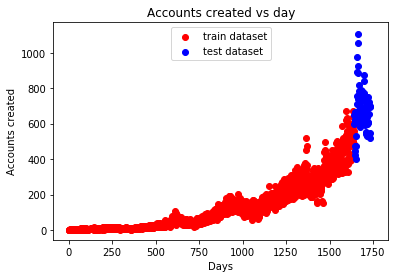

In [19]:
dac_train = train.date_account_created.value_counts()
dac_test = test.date_account_created.value_counts()
#将数据类型转换为datatime类型
dac_train_date = pd.to_datetime(train.date_account_created.value_counts().index)
dac_test_date = pd.to_datetime(test.date_account_created.value_counts().index)
#计算离首次注册时间相差的天数
dac_train_day = dac_train_date - dac_train_date.min()
dac_test_day = dac_test_date - dac_train_date.min()
#motplotlib作图
plt.scatter(dac_train_day.days, dac_train.values, color = 'r', label = 'train dataset')
plt.scatter(dac_test_day.days, dac_test.values, color = 'b', label = 'test dataset')

plt.title("Accounts created vs day")
plt.xlabel("Days")
plt.ylabel("Accounts created")
plt.legend(loc = 'upper center')

1. x轴表示离首次注册的天数，y轴表示当天注册的用户数量
2. 随着时间的增长,用户注册的数量在急剧上升

## 2. timestamp_first_active

In [22]:
train.timestamp_first_active.head()

0    20090319043255
1    20090523174809
2    20090609231247
3    20091031060129
4    20091208061105
Name: timestamp_first_active, dtype: int64

对数据进行统计看非重复值的数量

In [23]:
train.timestamp_first_active.value_counts().unique()

array([1], dtype=int64)

结果[1]表明timestamp_first_active没有重复数据

* 将object数据类型转换为时间数据类型

In [26]:
tfa_train=train.timestamp_first_active
tfa_train=train.timestamp_first_active.map(lambda x: datetime.datetime.strptime(str(x),'%Y%m%d%H%M%S'))
tfa_train.head()

0   2009-03-19 04:32:55
1   2009-05-23 17:48:09
2   2009-06-09 23:12:47
3   2009-10-31 06:01:29
4   2009-12-08 06:11:05
Name: timestamp_first_active, dtype: datetime64[ns]

### 查看用户一天中活跃的时间段

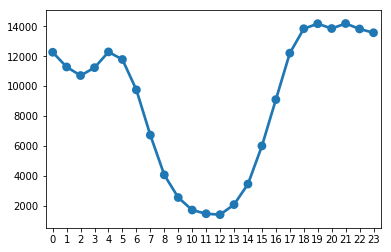

In [45]:
sns.pointplot(x=tfa_train.dt.hour.value_counts().index,y=tfa_train.dt.hour.value_counts().values)

用户首次活跃时间在一天中集中分布在17点之后到凌晨5点

## 3. date_first_booking

In [46]:
train.date_first_booking.describe()

count          88908
unique          1976
top       2014-05-22
freq             248
Name: date_first_booking, dtype: object

In [48]:
train.date_first_booking.isnull().sum()/213451

0.5834734904029496

首次订房时间缺失高达50%以上，可考虑删除该字段

## 4. age

In [52]:
train.age.value_counts(ascending=False).head(10)

30.0    6124
31.0    6016
29.0    5963
28.0    5939
32.0    5855
27.0    5738
33.0    5527
26.0    5044
34.0    5029
35.0    4860
Name: age, dtype: int64

用户年龄主要集中在30左右

Text(0,0.5,'counts')

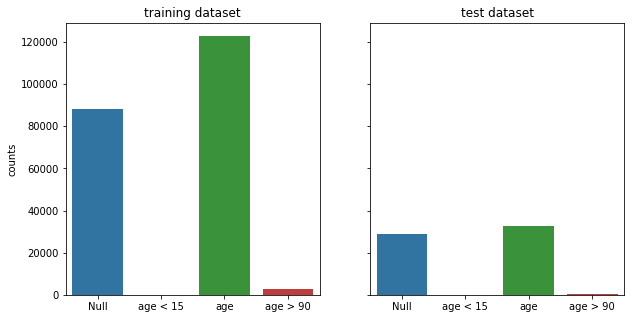

In [54]:
#首先将年龄进行分成4组missing values, too small age, reasonable age, too large age
age_train =[train[train.age.isnull()].age.shape[0],
            train.query('age < 15').age.shape[0],
            train.query("age >= 15 & age <= 90").age.shape[0],
            train.query('age > 90').age.shape[0]]

age_test = [test[test.age.isnull()].age.shape[0],
            test.query('age < 15').age.shape[0],
            test.query("age >= 15 & age <= 90").age.shape[0],
            test.query('age > 90').age.shape[0]]

columns = ['Null', 'age < 15', 'age', 'age > 90']

# plot
fig, (ax1,ax2) = plt.subplots(1,2,sharex=True, sharey = True,figsize=(10,5))

sns.barplot(columns, age_train, ax = ax1)
sns.barplot(columns, age_test, ax = ax2)

ax1.set_title('training dataset')
ax2.set_title('test dataset')
ax1.set_ylabel('counts')

In [56]:
#统一使用柱状图进行统计
def feature_barplot(feature, df_train = train, df_test = test, figsize=(10,5), rot = 90, saveimg = False): 
    feat_train = df_train[feature].value_counts()
    feat_test = df_test[feature].value_counts()
    fig_feature, (axis1,axis2) = plt.subplots(1,2,sharex=True, sharey = True, figsize = figsize)
    sns.barplot(feat_train.index.values, feat_train.values, ax = axis1)
    sns.barplot(feat_test.index.values, feat_test.values, ax = axis2)
    axis1.set_xticklabels(axis1.xaxis.get_majorticklabels(), rotation = rot)
    axis2.set_xticklabels(axis1.xaxis.get_majorticklabels(), rotation = rot)
    axis1.set_title(feature + ' of training dataset')
    axis2.set_title(feature + ' of test dataset')
    axis1.set_ylabel('Counts')
    plt.tight_layout()
    if saveimg == True:
        figname = feature + ".png"
        fig_feature.savefig(figname, dpi = 75)

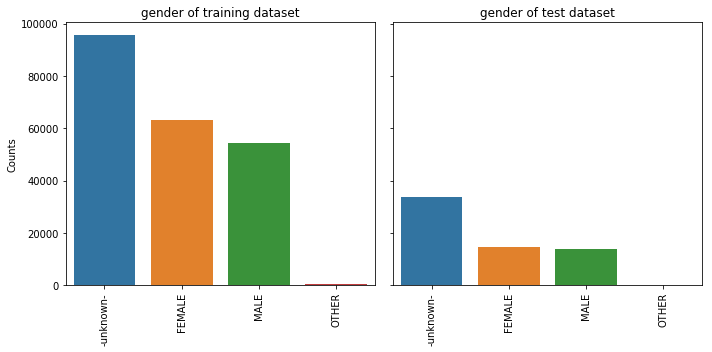

In [57]:
feature_barplot('gender', saveimg = True)

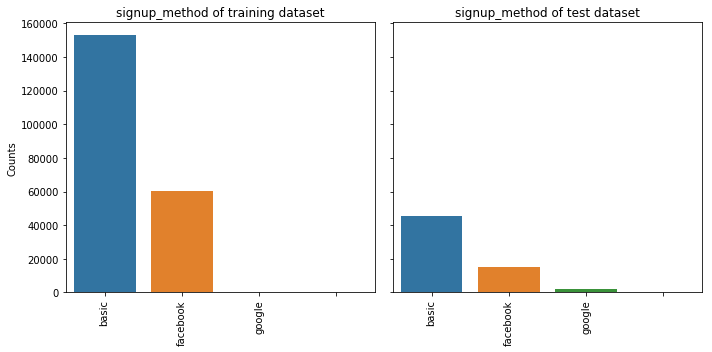

In [58]:
feature_barplot('signup_method')

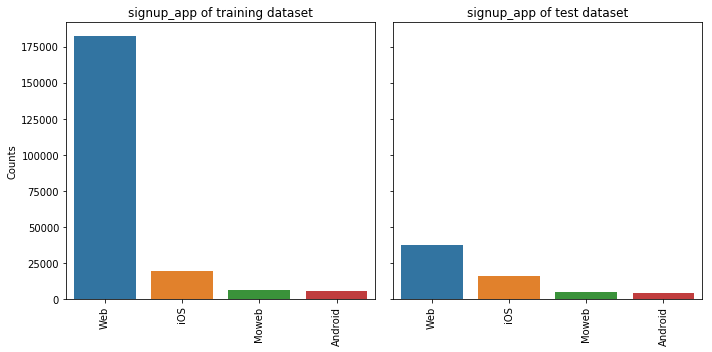

In [59]:
feature_barplot('signup_app')

# sesion文件

In [60]:
df_sessions=pd.read_csv('./input/sessions.csv')
df_sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,jpmpj40cvk,lookup,NaN,NaN,Windows Desktop,957.0


In [61]:
#将user_id改名为id
df_sessions.rename(columns={'user_id':'id'},inplace=True)

In [62]:
df_sessions.shape

(1048575, 6)

查看缺失值

In [63]:
df_sessions.isnull().sum()

id                 2797
action             7873
action_type      143097
action_detail    143097
device_type           0
secs_elapsed      11067
dtype: int64

1. action，action_type，action_detail， secs_elapsed缺失值较多
2. 填充缺失值，(此处用了字符串'NAN')

In [64]:
df_sessions.action = df_sessions.action.fillna('NAN')
df_sessions.action_type = df_sessions.action_type.fillna('NAN')
df_sessions.action_detail = df_sessions.action_detail.fillna('NAN')
df_sessions.isnull().sum()

id                2797
action               0
action_type          0
action_detail        0
device_type          0
secs_elapsed     11067
dtype: int64

#对action进行统计，我们可以发现用户action有多种，且最少的发生次数只有1，接下来我们可以对用户发生次数较少的行为列为OTHER一类

In [66]:
df_sessions.action.value_counts()[df_sessions.action.value_counts()<10]

payoneer_account_redirect          9
invalid_action                     9
redirect                           9
request_photography                8
pricing                            7
become_user                        7
press_content                      7
hospitality                        7
apply_code                         6
city_count                         6
multi                              6
onenight                           6
social                             5
ajax_send_message                  5
create_paypal                      5
apply                              5
new_session                        5
zendesk_login_jwt                  4
phone_verification                 4
google_importer                    4
payoneer_signup_complete           4
founders                           4
change_availability                4
ajax_photo_widget                  4
respond                            4
office_location                    3
press_news                         3
s

In [67]:
#Action values with low frequency are changed to 'OTHER'
act_freq = 100  #Threshold of frequency
act = dict(zip(*np.unique(df_sessions.action, return_counts=True)))
df_sessions.action = df_sessions.action.apply(lambda x: 'OTHER' if act[x] < act_freq else x)
#np.unique(df_sessions.action, return_counts=True) 取以数组形式返回非重复的action值和它的数量
#zip（*（a,b））a,b种元素一一对应，返回zip object

In [68]:
dict(zip(*np.unique(df_sessions.action,return_counts=True)))

{'10': 200,
 '12': 282,
 'NAN': 7873,
 'OTHER': 3184,
 'account': 1112,
 'active': 15855,
 'add_note': 161,
 'ajax_check_dates': 8387,
 'ajax_get_referrals_amt': 557,
 'ajax_image_upload': 1560,
 'ajax_lwlb_contact': 5042,
 'ajax_payout_edit': 103,
 'ajax_payout_options_by_country': 115,
 'ajax_photo_widget_form_iframe': 2424,
 'ajax_refresh_subtotal': 71482,
 'ajax_statsd': 307,
 'apply_reservation': 1272,
 'ask_question': 6994,
 'at_checkpoint': 497,
 'authenticate': 6021,
 'authorize': 127,
 'available': 717,
 'calendar_tab_inner2': 9353,
 'callback': 888,
 'campaigns': 2943,
 'cancellation_policies': 1592,
 'click': 555,
 'collections': 12763,
 'complete': 320,
 'complete_status': 1790,
 'confirm_email': 7424,
 'connect': 1000,
 'contact_new': 175,
 'create': 17262,
 'create_multiple': 153,
 'dashboard': 9535,
 'decision_tree': 308,
 'delete': 623,
 'domains': 438,
 'edit': 7716,
 'edit_verification': 2288,
 'facebook_auto_login': 550,
 'faq': 1192,
 'faq_category': 906,
 'faq_expe

首先将用户的特征根据用户id进行分组
- **特征action：**统计每个用户总的action出现的次数，各个action类型的数量，平均值以及标准差
- **特征action_detail：**统计每个用户总的action_detail出现的次数，各个action_detail类型的数量，平均值以及标准差
- **特征action_type：**统计每个用户总的action_type出现的次数，各个action_type类型的数量，平均值，标准差以及总的停留时长（进行log处理）
- **特征device_type：**统计每个用户总的device_type出现的次数，各个device_type类型的数量，平均值以及标准差
- **特征secs_elapsed：**对缺失值用0填充，统计每个用户secs_elapsed时间的总和，平均值，标准差以及中位数（进行log处理），（总和/平均数），secs_elapsed（log处理后）各个时间出现的次数

In [69]:
#对action特征进行细化
f_act = df_sessions.action.value_counts().argsort()
f_act_detail = df_sessions.action_detail.value_counts().argsort()
f_act_type = df_sessions.action_type.value_counts().argsort()
f_dev_type = df_sessions.device_type.value_counts().argsort()

#按照id进行分组
dgr_sess = df_sessions.groupby(['id'])
#Loop on dgr_sess to create all the features.
samples = [] #samples列表
ln = len(dgr_sess) #计算分组后df_sessions的长度

for g in dgr_sess:  #对dgr_sess中每个id的数据进行遍历
    gr = g[1]   #data frame that comtains all the data for a groupby value 'zzywmcn0jv'
    
    l = []  #建一个空列表，临时存放特征
    
    #the id    for example:'zzywmcn0jv'
    l.append(g[0]) #将id值放入空列表中
    
    # number of total actions
    l.append(len(gr))#将id对应数据的长度放入列表
    
    #secs_elapsed 特征中的缺失值用0填充再获取具体的停留时长值
    sev = gr.secs_elapsed.fillna(0).values   #These values are used later.
    
    #action features 特征-用户行为 
    #每个用户行为出现的次数，各个行为类型的数量，平均值以及标准差
    c_act = [0] * len(f_act)
    for i,v in enumerate(gr.action.values): #i是从0-1对应的位置，v 是用户行为特征的值
        c_act[f_act[v]] += 1
    _, c_act_uqc = np.unique(gr.action.values, return_counts=True)
    #计算用户行为行为特征各个类型数量的长度，平均值以及标准差
    c_act += [len(c_act_uqc), np.mean(c_act_uqc), np.std(c_act_uqc)]
    l = l + c_act
    
    #action_detail features 特征-用户行为具体
    #(how many times each value occurs, numb of unique values, mean and std)
    c_act_detail = [0] * len(f_act_detail)
    for i,v in enumerate(gr.action_detail.values):
        c_act_detail[f_act_detail[v]] += 1
    _, c_act_det_uqc = np.unique(gr.action_detail.values, return_counts=True)
    c_act_detail += [len(c_act_det_uqc), np.mean(c_act_det_uqc), np.std(c_act_det_uqc)]
    l = l + c_act_detail
    
    #action_type features  特征-用户行为类型 click等
    #(how many times each value occurs, numb of unique values, mean and std
    #+ log of the sum of secs_elapsed for each value)
    l_act_type = [0] * len(f_act_type)
    c_act_type = [0] * len(f_act_type)
    for i,v in enumerate(gr.action_type.values):
        l_act_type[f_act_type[v]] += sev[i] #sev = gr.secs_elapsed.fillna(0).values ，求每个行为类型总的停留时长
        c_act_type[f_act_type[v]] += 1  
    l_act_type = np.log(1 + np.array(l_act_type)).tolist() #每个行为类型总的停留时长，差异比较大，进行log处理
    _, c_act_type_uqc = np.unique(gr.action_type.values, return_counts=True)
    c_act_type += [len(c_act_type_uqc), np.mean(c_act_type_uqc), np.std(c_act_type_uqc)]
    l = l + c_act_type + l_act_type    
    
    #device_type features 特征-设备类型
    #(how many times each value occurs, numb of unique values, mean and std)
    c_dev_type  = [0] * len(f_dev_type)
    for i,v in enumerate(gr.device_type .values):
        c_dev_type[f_dev_type[v]] += 1 
    c_dev_type.append(len(np.unique(gr.device_type.values))) 
    _, c_dev_type_uqc = np.unique(gr.device_type.values, return_counts=True)
    c_dev_type += [len(c_dev_type_uqc), np.mean(c_dev_type_uqc), np.std(c_dev_type_uqc)]        
    l = l + c_dev_type    
    
    #secs_elapsed features  特征-停留时长     
    l_secs = [0] * 5 
    l_log = [0] * 15
    if len(sev) > 0:
        #Simple statistics about the secs_elapsed values.
        l_secs[0] = np.log(1 + np.sum(sev))
        l_secs[1] = np.log(1 + np.mean(sev)) 
        l_secs[2] = np.log(1 + np.std(sev))
        l_secs[3] = np.log(1 + np.median(sev))
        l_secs[4] = l_secs[0] / float(l[1]) #
        
        #Values are grouped in 15 intervals. Compute the number of values
        #in each interval.
        #sev = gr.secs_elapsed.fillna(0).values 
        log_sev = np.log(1 + sev).astype(int)
        #np.bincount():Count number of occurrences of each value in array of non-negative ints.  
        l_log = np.bincount(log_sev, minlength=15).tolist()                    
    l = l + l_secs + l_log
    
    #The list l has the feature values of one sample.
    samples.append(l)

#preparing objects    
samples = np.array(samples) 
samp_ar = samples[:, 1:].astype(np.float16) #取除id外的特征数据
samp_id = samples[:, 0]   #取id，id位于第一列

#为提取的特征创建一个dataframe     
col_names = []    #name of the columns
for i in range(len(samples[0])-1):  #减1的原因是因为有个id
    col_names.append('c_' + str(i))  #起名字的方式    
df_agg_sess = pd.DataFrame(samp_ar, columns=col_names)
df_agg_sess['id'] = samp_id
df_agg_sess.index = df_agg_sess.id #将id作为index

In [70]:
df_agg_sess.tail()

,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,...,c_284,c_285,c_286,c_287,c_288,c_289,c_290,c_291,c_292,id
id,,,,,,,,,,,,,,,,,,,,,
zzqb2sn066,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,zzqb2sn066
zzrnx9rqi5,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,3.0,1.0,1.0,5.0,0.0,1.0,1.0,0.0,zzrnx9rqi5
zzv8sgicbk,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,3.0,4.0,3.0,3.0,2.0,1.0,0.0,0.0,zzv8sgicbk
zzvatt4dio,422.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,108.0,79.0,26.0,41.0,32.0,20.0,8.0,3.0,2.0,zzvatt4dio
zzywmcn0jv,51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,15.0,5.0,5.0,1.0,3.0,2.0,2.0,0.0,zzywmcn0jv


In [71]:
df_agg_sess.shape

(15588, 294)

## 4.2 对trian和test文件进行特征提取

In [72]:
#计算出train的行数，便于之后对train和test数据进行分离操作
train_row = train.shape[0]  

# The label we need to predict
labels = train['country_destination'].values

- 数据探索时我们发现date_first_booking在train和test文件中缺失值太多，故删除
- 删除country_destination，用模型预测country_destination，再与已经存储country_destination的labels进行比较，从而判断模型优劣

In [73]:
train.drop(['country_destination', 'date_first_booking'], axis = 1, inplace = True)
test.drop(['date_first_booking'], axis = 1, inplace = True)

合并train和test文件
- 便于进行相同的特征提取操作

In [74]:
#连接test 和 train
df = pd.concat([train, test], axis = 0, ignore_index = True)

In [75]:
df.shape

(275547, 14)

## timestamp_first_active 
1.1转换为datetime类型

In [76]:
tfa=df.timestamp_first_active.astype(str).apply(lambda x: datetime.datetime(int(x[:4]),
                                                                          int(x[4:6]), 
                                                                          int(x[6:8]),
                                                                          int(x[8:10]),
                                                                          int(x[10:12]),
                                                                          int(x[12:])))

1.2 提取特征：年，月，日

In [77]:
# create tfa_year, tfa_month, tfa_day feature
df['tfa_year'] = np.array([x.year for x in tfa])
df['tfa_month'] = np.array([x.month for x in tfa])
df['tfa_day'] = np.array([x.day for x in tfa])

1.3 提取特征：weekday
- 对结果进行one hot encoding编码

In [78]:
#isoweekday() 可以返回一周的星期几，e.g.星期日：0；星期一：1
df['tfa_wd'] = np.array([x.isoweekday() for x in tfa]) 
df_tfa_wd = pd.get_dummies(df.tfa_wd, prefix = 'tfa_wd')  # one hot encoding 
df = pd.concat((df, df_tfa_wd), axis = 1) #添加df['tfa_wd'] 编码后的特征
df.drop(['tfa_wd'], axis = 1, inplace = True)#删除原有未编码的特征

1.4 提取特征：季节
- 因为判断季节关注的是月份，故对年份进行统一

In [79]:
Y = 2000
seasons = [(0, (date(Y,  1,  1),  date(Y,  3, 20))),  #'winter'
           (1, (date(Y,  3, 21),  date(Y,  6, 20))),  #'spring'
           (2, (date(Y,  6, 21),  date(Y,  9, 22))),  #'summer'
           (3, (date(Y,  9, 23),  date(Y, 12, 20))),  #'autumn'
           (0, (date(Y, 12, 21),  date(Y, 12, 31)))]  #'winter'

def get_season(dt):
    dt = dt.date() #获取日期
    dt = dt.replace(year=Y) #将年统一换成2000年
    return next(season for season, (start, end) in seasons if start <= dt <= end)

df['tfa_season'] = np.array([get_season(x) for x in tfa])
df_tfa_season = pd.get_dummies(df.tfa_season, prefix = 'tfa_season') # one hot encoding 
df = pd.concat((df, df_tfa_season), axis = 1)
df.drop(['tfa_season'], axis = 1, inplace = True)

## 2. date_account_created
2.1 将date_account_created转换为datetime类型

In [80]:
dac = pd.to_datetime(df.date_account_created)

2.2 提取特征：年，月，日

In [81]:
# create year, month, day feature for dac

df['dac_year'] = np.array([x.year for x in dac])
df['dac_month'] = np.array([x.month for x in dac])
df['dac_day'] = np.array([x.day for x in dac])

2.3 提取特征：weekday

In [82]:
# create features of weekday for dac

df['dac_wd'] = np.array([x.isoweekday() for x in dac])
df_dac_wd = pd.get_dummies(df.dac_wd, prefix = 'dac_wd')
df = pd.concat((df, df_dac_wd), axis = 1)
df.drop(['dac_wd'], axis = 1, inplace = True)

2.4 提取特征：季节

In [83]:
# create season features fro dac

df['dac_season'] = np.array([get_season(x) for x in dac])
df_dac_season = pd.get_dummies(df.dac_season, prefix = 'dac_season')
df = pd.concat((df, df_dac_season), axis = 1)
df.drop(['dac_season'], axis = 1, inplace = True)

2.5提取特征：date_account_created和timestamp_first_active之间的差值
- 即用户在airbnb平台活跃到正式注册所花的时间

In [84]:
dt_span = dac.subtract(tfa).dt.days 

In [85]:
dt_span.value_counts().head(10)

-1     275369
 0          7
 6          4
 5          4
 1          4
 2          3
 3          3
 4          3
 28         3
 94         2
dtype: int64

分析：数据主要集中在-1，可以猜测，用户当天注册dt_span值便是-1

    从差值提取特征：差值为一天，一月，一年和其他
    即用户活跃到注册花费的时间为一天，一月，一年或其他

In [86]:
# create categorical feature: span = -1; -1 < span < 30; 31 < span < 365; span > 365
def get_span(dt):
    # dt is an integer
    if dt == -1:
        return 'OneDay'
    elif (dt < 30) & (dt > -1):
        return 'OneMonth'
    elif (dt >= 30) & (dt <= 365):
        return 'OneYear'
    else:
        return 'other'

df['dt_span'] = np.array([get_span(x) for x in dt_span])
df_dt_span = pd.get_dummies(df.dt_span, prefix = 'dt_span')
df = pd.concat((df, df_dt_span), axis = 1)
df.drop(['dt_span'], axis = 1, inplace = True)

In [87]:
#对timestamp_first_active，date_account_created进行特征提取后，从特征列表中删除原有的特征
df.drop(['date_account_created','timestamp_first_active'], axis = 1, inplace = True)

## age

In [88]:
#Age 获取年龄
av = df.age.values

在数据探索阶段，我们发现大部分数据是集中在（15，90）区间的，但有部分年龄分布在（1900，2000）区间，我们猜测用户是把出生日期误填为年龄，故进行预处理

In [89]:
#This are birthdays instead of age (estimating age by doing 2014 - value)
#数据来自2014年，故用2014-value
av = np.where(np.logical_and(av<2000, av>1900), 2014-av, av) 
df['age'] = av

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


3.1 将年龄进行分段

In [90]:
# Age has many abnormal values that we need to deal with. 
age = df.age
age.fillna(-1, inplace = True) #空值填充为-1
div = 15
def get_age(age):
    # age is a float number  将连续型转换为离散型
    if age < 0:
        return 'NA' #表示是空值
    elif (age < div):
        return div #如果年龄小于15岁，那么返回15岁
    elif (age <= div * 2):
        return div*2 #如果年龄大于15小于等于30岁，则返回30岁
    elif (age <= div * 3):
        return div * 3
    elif (age <= div * 4):
        return div * 4
    elif (age <= div * 5):
        return div * 5
    elif (age <= 110):
        return div * 6
    else:
        return 'Unphysical' #非正常年龄

In [91]:
#将分段后的年龄作为新的特征放入特征列表中
df['age'] = np.array([get_age(x) for x in age])
df_age = pd.get_dummies(df.age, prefix = 'age')
df = pd.concat((df, df_age), axis = 1)
df.drop(['age'], axis = 1, inplace = True)

## 4. 其他特征
在数据探索时，我们发现剩余的特征lables都比较少，故不进一步进行特征提取，只进行one-hot-encoding处理

In [92]:
feat_toOHE = ['gender', 
             'signup_method', 
             'signup_flow', 
             'language', 
             'affiliate_channel', 
             'affiliate_provider', 
             'first_affiliate_tracked', 
             'signup_app', 
             'first_device_type', 
             'first_browser']
#对其他特征进行one-hot-encoding处理
for f in feat_toOHE:
    df_ohe = pd.get_dummies(df[f], prefix=f, dummy_na=True)
    df.drop([f], axis = 1, inplace = True)
    df = pd.concat((df, df_ohe), axis = 1)

## 4.3 整合提取的所有特征

    我们将对session以及train，test文件中提取的特征进行合并


In [93]:
#将对session提取的特征整合到一起
df_all = pd.merge(df, df_agg_sess, how='left')
df_all = df_all.drop(['id'], axis=1) #删除id
df_all = df_all.fillna(-2)  #对没有sesssion data的特征进行缺失值处理

#加了一列，表示每一行总共有多少空值，这也作为一个特征
df_all['all_null'] = np.array([sum(r<0) for r in df_all.values]) 

# 5. 模型构建

5.1 数据准备
1. 将train和test数据进行分离操作
2. train_row是之前记录的train数据行数

In [94]:
Xtrain = df_all.iloc[:train_row, :]
Xtest = df_all.iloc[train_row:, :]

2. 将提取的特征生成csv文件

In [95]:
Xtrain.to_csv("Airbnb_xtrain_v2.csv")
Xtest.to_csv("Airbnb_xtest_v2.csv")
#labels.tofile（）：Write array to a file as text or binary (default)
labels.tofile("Airbnb_ytrain_v2.csv", sep='\n', format='%s') #存放目标变量

In [96]:
#读取特征文件
xtrain = pd.read_csv("Airbnb_xtrain_v2.csv",index_col=0)
ytrain = pd.read_csv("Airbnb_ytrain_v2.csv", header=None)
xtrain.head()

,tfa_year,tfa_month,tfa_day,tfa_wd_1,tfa_wd_2,tfa_wd_3,tfa_wd_4,tfa_wd_5,tfa_wd_6,tfa_wd_7,...,c_284,c_285,c_286,c_287,c_288,c_289,c_290,c_291,c_292,all_null
0,2009,3,19,0,0,0,1,0,0,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,293
1,2009,5,23,0,0,0,0,0,1,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,293
2,2009,6,9,0,1,0,0,0,0,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,293
3,2009,10,31,0,0,0,0,0,1,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,293
4,2009,12,8,0,1,0,0,0,0,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,293


In [97]:
ytrain.head()

,0
0,NDF
1,NDF
2,US
3,other
4,US


3. 将目标变量进行labels encoding

In [98]:
le = LabelEncoder()
ytrain_le = le.fit_transform(ytrain.values)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [99]:
ytrain_le

array([ 7,  7, 10, ...,  7,  7,  7], dtype=int64)

4. 提取10%的数据进行模型训练

    减少训练模型花费的时间

In [100]:
# Let us take 10% of the data for faster training. 
n = int(xtrain.shape[0]*0.1)
xtrain_new = xtrain.iloc[:n, :]  #训练数据
ytrain_new = ytrain_le[:n]       #训练数据的目标变量

## 5. StandardScaling the dataset
- Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual feature do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance)

In [101]:
X_scaler = StandardScaler()
xtrain_new = X_scaler.fit_transform(xtrain_new)

### 5.2 评分模型：NDCG

- NDCG是一种衡量排序质量的评价指标，该指标考虑了所有元素的相关性
- 由于我们预测的目标变量并不是二分类变量，故我们用NDGG模型来进行模型评分，判断模型优劣
- 一般二分类变量: 我们习惯于使用 f1 score, precision, recall, auc score来进行模型评分


In [102]:
from sklearn.metrics import make_scorer

def dcg_score(y_true, y_score, k=5):
    
    """
    y_true : array, shape = [n_samples] #数据
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes] #预测的分数
        Predicted scores.
    k : int
    """
    order = np.argsort(y_score)[::-1] #分数从高到低排序
    y_true = np.take(y_true, order[:k]) #取出前k[0,k）个分数
      
    gain = 2 ** y_true - 1   

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)
  

def ndcg_score(ground_truth, predictions, k=5):   

    """
    Parameters
    ----------
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes] 
        Predicted probabilities. 预测的概率
    k : int
        Rank.
    """
    lb = LabelBinarizer()
    lb.fit(range(len(predictions) + 1))
    T = lb.transform(ground_truth)    
    scores = []
    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)

## 6. 构建模型
### 6.1 Logistic Regression

In [103]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [104]:
lr = LogisticRegression(C = 1.0, penalty='l2', multi_class='ovr')
RANDOM_STATE = 2019 #随机种子

#k-fold cross validation(k-折叠交叉验证)
kf=KFold(n_splits=5,random_state=RANDOM_STATE) # 分成5个组
train_score=[]
cv_score=[]

#select a k 
k_ndcg = 3
#kf.split:Generate indices to split data into training and test set.
for train_index,test_index in kf.split(xtrain_new,ytrain_new):
    #训练集数据分割为训练集和测试集，y是目标变量
    X_train,X_test=xtrain_new[train_index,:],xtrain_new[test_index,:]
    y_train,y_test=ytrain_new[train_index],ytrain_new[test_index]
    
    lr.fit(X_train,y_train)
    
    y_pred = lr.predict_proba(X_test)
    train_ndcg_score = ndcg_score(y_train,lr.predict_proba(X_train),k=k_ndcg)
    cv_ndcg_score = ndcg_score(y_test,y_pred,k=k_ndcg)
    
    train_score.append(train_ndcg_score)
    cv_score.append(cv_ndcg_score)

print("\nThe training score is:{}".format(np.mean(train_score)))
print("\nThe cv score is :{}".format(np.mean(cv_score)))


The training score is:0.7595157690333219

The cv score is :0.7417455860527811


learning curve of logistic regression

    观察逻辑回归模型学习曲线的变化
    1. 改变逻辑回归参数iteration


In [105]:
#set the iterations
iteration =[1,5,10,15,20,50,100]

kf=KFold(n_splits=3,random_state=RANDOM_STATE)

train_score=[]
cv_score=[]

#select a k:
k_ndcg=5

for i,item in enumerate(iteration):
    lr = LogisticRegression(C=1.0,max_iter=item,tol=1e-5,solver='newton-cg',multi_class='ovr')
    train_score_iter = []
    cv_score_iter = []
    
    for train_index,test_index in kf.split(xtrain_new,ytrain_new):
        X_train,X_test = xtrain_new[train_index,:],xtrain_new[test_index,:]
        y_train,y_test = ytrain_new[train_index],ytrain_new[test_index]
        
        lr.fit(X_train,y_train)
        
        y_pred = lr.predict_proba(X_test)
        train_ndcg_score = ndcg_score(y_train,lr.predict_proba(X_train),k = k_ndcg)
        cv_ndcg_score = ndcg_score(y_test,y_pred,k=k_ndcg)
        
        train_score_iter.append(train_ndcg_score)
        cv_score_iter.append(cv_ndcg_score)
    
    train_score.append(np.mean(train_score_iter))
    cv_score.append(np.mean(cv_score_iter))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


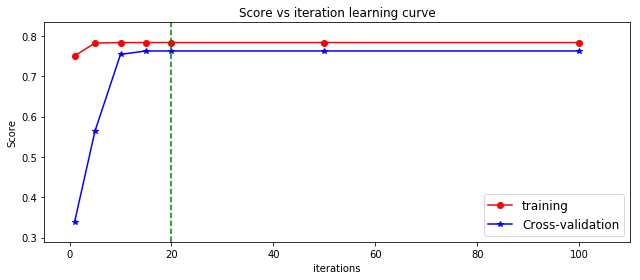

In [106]:
ymin=np.min(cv_score)-0.05
ymax = np.max(train_score)+0.05

plt.figure(figsize=(9,4))
plt.plot(iteration,train_score,'ro-',label='training')
plt.plot(iteration,cv_score,'b*-',label='Cross-validation')
plt.xlabel('iterations')
plt.ylabel('Score')
plt.xlim(-5,np.max(iteration)+10)
plt.ylim(ymin,ymax)
plt.plot(np.linspace(20,20,50),np.linspace(ymin,ymax,50),'g--')
plt.legend(loc='lower right',fontsize=12)
plt.title("Score vs iteration learning curve")
plt.tight_layout()

分析：随着iteration的增大，逻辑回归模型的评分在不断升高，当iteration超过20的时候，模型的评分基本不变

2. 改变数据量大小

In [107]:
# Chaning the sampling size
# set the iter to the best iteration: iter = 20

perc = [0.01,0.02,0.05,0.1,0.2,0.5,1]

kf = KFold(n_splits=3, random_state=RANDOM_STATE)

train_score = []
cv_score = []

# select a k:
k_ndcg = 5

for i, item in enumerate(perc):
    
    lr = LogisticRegression(C=1.0, max_iter=20, tol=1e-6, solver='newton-cg', multi_class='ovr')
    train_score_iter = []
    cv_score_iter = []
    
    n = int(xtrain_new.shape[0]*item)
    xtrain_perc = xtrain_new[:n, :]
    ytrain_perc = ytrain_new[:n]


    for train_index, test_index in kf.split(xtrain_perc, ytrain_perc):
        
        X_train, X_test = xtrain_perc[train_index, :], xtrain_perc[test_index, :]
        y_train, y_test = ytrain_perc[train_index], ytrain_perc[test_index]

        print(X_train.shape, X_test.shape)
        
        lr.fit(X_train, y_train)

        y_pred = lr.predict_proba(X_test)
        train_ndcg_score = ndcg_score(y_train, lr.predict_proba(X_train), k = k_ndcg)
        cv_ndcg_score = ndcg_score(y_test, y_pred, k=k_ndcg)

        train_score_iter.append(train_ndcg_score)
        cv_score_iter.append(cv_ndcg_score)
        
    train_score.append(np.mean(train_score_iter))
    cv_score.append(np.mean(cv_score_iter))

(142, 497) (71, 497)
(142, 497) (71, 497)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


(142, 497) (71, 497)
(284, 497) (142, 497)
(284, 497) (142, 497)
(284, 497) (142, 497)
(711, 497) (356, 497)
(711, 497) (356, 497)
(712, 497) (355, 497)
(1422, 497) (712, 497)
(1423, 497) (711, 497)
(1423, 497) (711, 497)
(2846, 497) (1423, 497)
(2846, 497) (1423, 497)
(2846, 497) (1423, 497)
(7114, 497) (3558, 497)
(7115, 497) (3557, 497)
(7115, 497) (3557, 497)
(14230, 497) (7115, 497)
(14230, 497) (7115, 497)
(14230, 497) (7115, 497)


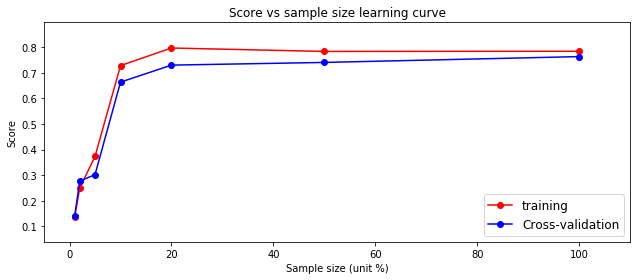

In [108]:
ymin = np.min(cv_score)-0.1
ymax = np.max(train_score)+0.1

plt.figure(figsize=(9,4))
plt.plot(np.array(perc)*100, train_score, 'ro-', label = 'training')
plt.plot(np.array(perc)*100, cv_score, 'bo-', label = 'Cross-validation')
plt.xlabel("Sample size (unit %)")
plt.ylabel("Score")
plt.xlim(-5, np.max(perc)*100+10)
plt.ylim(ymin, ymax)

plt.legend(loc = 'lower right', fontsize = 12)
plt.title("Score vs sample size learning curve")

plt.tight_layout()

分析：随着数据量的增加，逻辑回归模型对测试集的预测评分（蓝色线）在不断上升，因为我们在训练模型时只用了10%的数据，如果使用全部的数据，效果可能会更好

6.2 树模型

    其中的模型包括DecisionTree，RandomForest，AdaBoost，Bagging，ExtraTree，GraBoost


In [109]:
from sklearn.ensemble import AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import *
from sklearn.svm import SVC ,LinearSVC,NuSVC
LEARNING_RATE = 0.1
N_ESTIMATORS = 50
RANDOM_STATE = 2019
MAX_DEPTH = 9

#建了一个tree字典
clf_tree={
    'DTree':DecisionTreeClassifier(max_depth=MAX_DEPTH,random_state=RANDOM_STATE),
    'RF':RandomForestClassifier(n_estimators=N_ESTIMATORS,max_depth=MAX_DEPTH,random_state=RANDOM_STATE),
    'AdaBoost':BaggingClassifier(n_estimators=N_ESTIMATORS,random_state=RANDOM_STATE),
    'ExtraTree':ExtraTreesClassifier(max_depth=MAX_DEPTH,n_estimators=N_ESTIMATORS,random_state=RANDOM_STATE),
    'GraBoost':GradientBoostingClassifier(learning_rate=LEARNING_RATE,max_depth=MAX_DEPTH,n_estimators=N_ESTIMATORS,random_state=RANDOM_STATE)
}
train_score=[]
cv_score=[]

kf=KFold(n_splits=3,random_state=RANDOM_STATE)

k_ndcg=5

for key in clf_tree.keys():
    clf=clf_tree.get(key)
    
    train_score_iter=[]
    cv_score_iter=[]
    
    for train_index,test_index in kf.split(xtrain_new,ytrain_new):
        X_train,X_test = xtrain_new[train_index,:],xtrain_new[test_index,:]
        y_train,y_test = ytrain_new[train_index],ytrain_new[test_index]
        
        clf.fit(X_train,y_train)
        
        y_pred = clf.predict_proba(X_test)
        train_ndcg_score = ndcg_score(y_train,clf.predict_proba(X_train),k=k_ndcg)
        cv_ndcg_score = ndcg_score(y_test,y_pred,k=k_ndcg)
        
        train_score_iter.append(train_ndcg_score)
        cv_score_iter.append(cv_ndcg_score)
    
    train_score.append(np.mean(train_score_iter))
    cv_score.append(np.mean(cv_score_iter))

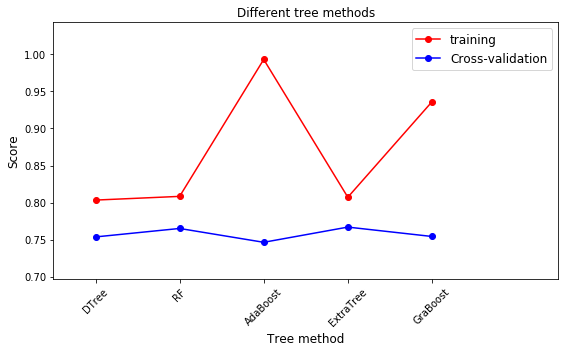

In [110]:
train_score_tree = train_score
cv_score_tree = cv_score

ymin = np.min(cv_score)-0.05
ymax = np.max(train_score)+0.05

x_ticks = clf_tree.keys()

plt.figure(figsize=(8,5))
plt.plot(range(len(x_ticks)), train_score_tree, 'ro-', label = 'training')
plt.plot(range(len(x_ticks)),cv_score_tree, 'bo-', label = 'Cross-validation')

plt.xticks(range(len(x_ticks)),x_ticks,rotation = 45, fontsize = 10)
plt.xlabel("Tree method", fontsize = 12)
plt.ylabel("Score", fontsize = 12)
plt.xlim(-0.5, 5.5)
plt.ylim(ymin, ymax)

plt.legend(loc = 'best', fontsize = 12)
plt.title("Different tree methods")

plt.tight_layout()